# Objective:
1. *Build Deep learning Model for Sequential Sentence Classification, for Converting “Harder to Read” text into “Easier to Read ” text.*
2. *Approach:Create many to one model*
3. Use following models
    1. Naïve Bayes with TF-IDF encoder (baseline)
    2. Conv1D with token embedding
    3. Pertained Feature Extractor
    4. Conv1D with character embedding



# Dataset details :

[*Original Paper: PubMed 200k RCT : a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)

PubMed 20k RCT is dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 20,000 abstracts of randomized controlled trials. Each sentence of each abstract is labelled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold.
First, the majority of datasets for sequential short-text classification i.e., classification of short texts that appear in sequences.
Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [1]:
# Downloading the pubmed_20k_RCT from github repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* train.txt -This contains list of training set.
* dev.txt - This contains the development set (i.e validation set)
* test.txt - This file contains the test set

In [3]:
#storing the PubMed_20k_RCT dataset in reference variable for future use
datafile_directory = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import random

### Explore & Preprocess Data

In [5]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [6]:
#Loading the data
train_data = get_raw_data(datafile_directory + 'train.txt')
#Viewing first 15 records from training dataset file
train_data[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

 In the dataset, each abstract in the dataset is delineated by a newline character ('\n'). Additionally, each abstract commences with '###', followed by the abstract ID and another newline. Within each abstract, individual lines begin with the target value we aim to predict, followed by the corresponding text of the abstract line. In the below function preprocessing is performed on the raw data and abstract ids and newlines are omitted from the returned preprocessed data.








In [7]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'):
            abstract_id = int(line.replace('###', '').replace('\n', ''))
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end
            abstract_data_split = abstract_data.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")


                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines
                line_data["target"] = target_text_split[0] # get target label

                abstract_samples.append(line_data)

        else:
            abstract_data += line

    return abstract_samples

In [8]:
#Preprocessing data in train,test and validation sets
train_set_samples = preprocess_raw_data(datafile_directory + "train.txt")
validation_set_samples = preprocess_raw_data(datafile_directory + "dev.txt")
test_set_samples = preprocess_raw_data(datafile_directory + "test.txt")


In [9]:
train_count = len(train_set_samples)
val_count = len(validation_set_samples)
test_count = len(test_set_samples)
print(f'train set samples count:\t{train_count}')
print(f'validation set samples count:\t{val_count}')
print(f'test set samples count:\t\t{test_count}')


train set samples count:	180040
validation set samples count:	30212
test set samples count:		30135


In [10]:
train_set_samples[:20]

[{'abstract_text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'target': 'OBJECTIVE'},
 {'abstract_text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Secondary outcome measures inclu

In [11]:
#converting train,test,validation samples into dataframes
train_df = pd.DataFrame(train_set_samples)
val_df = pd.DataFrame(validation_set_samples)
test_df = pd.DataFrame(test_set_samples)
train_df.head(20)

,abstract_text,line_number,total_lines,target
0,To investigate the efficacy of @ weeks of dail...,0,12,OBJECTIVE
1,A total of @ patients with primary knee OA wer...,1,12,METHODS
2,Outcome measures included pain reduction and i...,2,12,METHODS
3,Pain was assessed using the visual analog pain...,3,12,METHODS
4,Secondary outcome measures included the Wester...,4,12,METHODS
5,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12,METHODS
6,There was a clinically relevant reduction in t...,6,12,RESULTS
7,The mean difference between treatment arms ( @...,7,12,RESULTS
8,"Further , there was a clinically relevant redu...",8,12,RESULTS
9,These differences remained significant at @ we...,9,12,RESULTS


In [12]:
# Check training data distribution
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

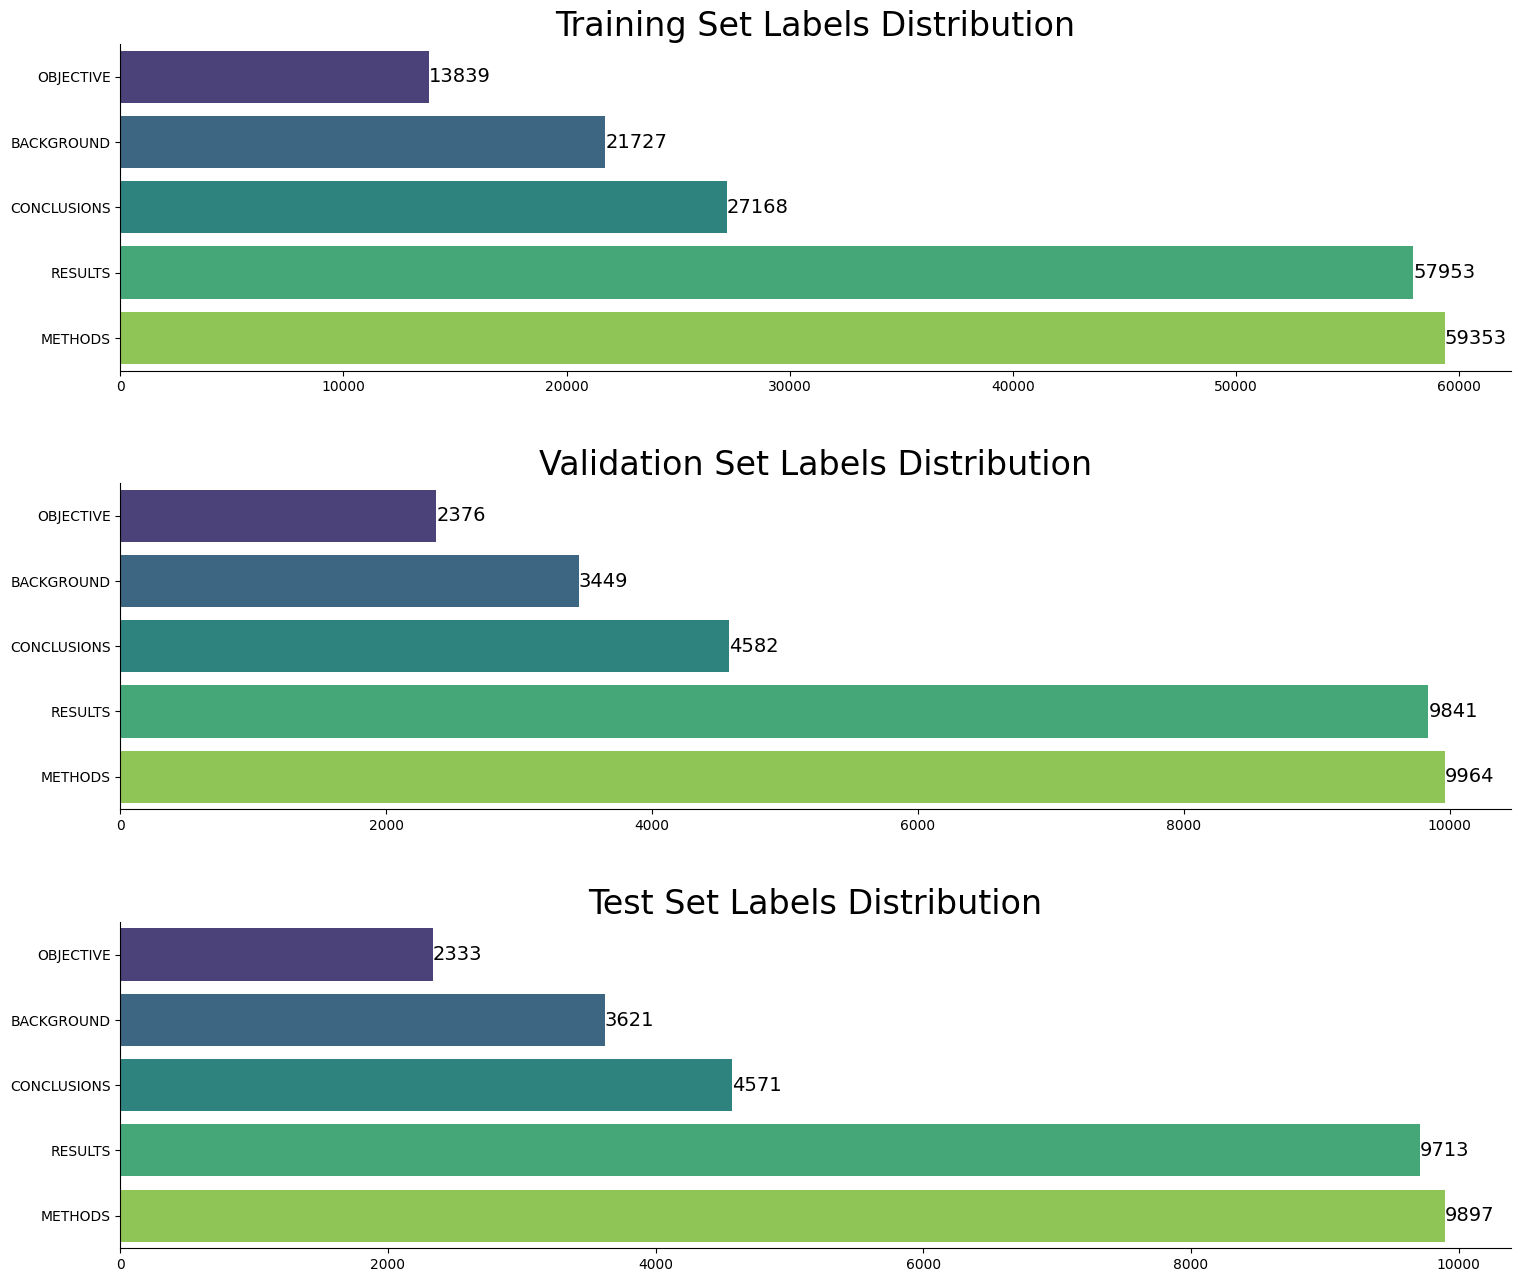

In [13]:
# Create subplots
fig, (ax_train, ax_val, ax_test) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();

# Plot Training Set Labels Distribution
ax_train.set_title('Training Set Labels Distribution', fontsize=24)
train_dist = train_df['target'].value_counts().sort_values()
train_bar_plot = sns.barplot(x=train_dist.values,
                            y=list(train_dist.keys()),
                            orient="h", palette=sns.color_palette("viridis", 5),
                            ax=ax_train);

for container in train_bar_plot.containers:
    train_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Validation Set Labels Distribution
ax_val.set_title('Validation Set Labels Distribution', fontsize=24)
val_dist = val_df['target'].value_counts().sort_values()
val_bar_plot = sns.barplot(x=val_dist.values,
                           y=list(val_dist.keys()),
                           orient="h", palette=sns.color_palette("viridis", 5),
                           ax=ax_val);

for container in val_bar_plot.containers:
    val_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Test Set Labels Distribution
ax_test.set_title('Test Set Labels Distribution', fontsize=24)
test_dist = test_df['target'].value_counts().sort_values()
test_bar_plot = sns.barplot(x=test_dist.values,
                            y=list(test_dist.keys()),
                            orient="h", palette=sns.color_palette("viridis", 5),
                            ax=ax_test);

for container in test_bar_plot.containers:
    test_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.show()

<Axes: ylabel='Frequency'>

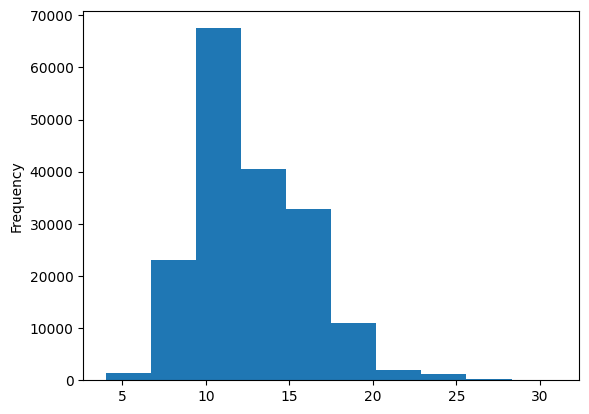

In [14]:
train_df.total_lines.plot(kind= "hist")

Based on the above histogram,it can be inferred that the abstracts are between 7 to 15 sentences in length.

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [16]:
train_sentences[:15]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

### Using One Hot Encoding to one hot encode the train,test and validation set labels


In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
train_df["target"][0]

'OBJECTIVE'

In [19]:
#Check one hot encoded training label
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())



In [21]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [23]:
print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Model 0: Baseline (Naïve Bayes with TF-IDF encoder)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a SKlearn pipeline using TF-IDF  and Multinomial Naive bayes algorithm
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])


In [25]:
#fitting on train dataset
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [26]:

# Perform evaluation on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [27]:
val_predictions = model_0.predict(val_sentences)
test_predictions = model_0.predict(test_sentences)


In [28]:
val_predictions


array([4, 1, 3, ..., 4, 4, 1])

In [29]:
test_predictions

array([2, 2, 2, ..., 4, 4, 4])

In [30]:
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

#Performance metrics summary
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.49      0.56      3449
 CONCLUSIONS       0.65      0.59      0.61      4582
     METHODS       0.72      0.87      0.79      9964
   OBJECTIVE       0.75      0.14      0.23      2376
     RESULTS       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



In [31]:
def generate_performance_scores(y_true, y_pred):

    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)

    performance_dict = {
        'accuracy': model_accuracy,
        'precision': model_precision,
        'recall': model_recall,
        'f1': model_f1
    }

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('=============================================')

    return performance_dict

### Model_0 Results

In [32]:
model_0_results= generate_performance_scores(val_labels_encoded, val_predictions)


Performance Metrics:

accuracy_score:		0.72183

_____________________________________________
precision_score:	0.71865

_____________________________________________
recall_score:		0.72183

_____________________________________________
f1_score:		0.69893



# Preparing data in format suitable for deep learning models






Vectorization and embedding layers needs to be created so data is in suitable format for Deep learning model

The vectorization layer is going to be used to convert text to numbers and the embedding layer is going to be used to capture the relationships between those numbers.

In [33]:
#The below analysis is being done to know the average,max and min length of sentences in order to ensure when tensorflow model is created the batch size of tensors can be decided so that all batches can have equal size tensors
# Create a list to store the lengths of sentences in the training set
sentence_lengths = []

# Iterate over each sentence in the training set
for sentence in train_sentences:
    # Split the sentence into words and calculate the length
    words_in_sentence = sentence.split()
    length_of_sentence = len(words_in_sentence)

    # Append the length of the sentence to the list
    sentence_lengths.append(length_of_sentence)

# Calculate the average sentence length using NumPy
average_sentence_length = np.mean(sentence_lengths)

# Print the average sentence length
print("Average Sentence Length:", average_sentence_length)

#Min Sentence length
print(min(sentence_lengths))

#Max Sentence length
print(max(sentence_lengths))

Average Sentence Length: 26.338269273494777
1
296


(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

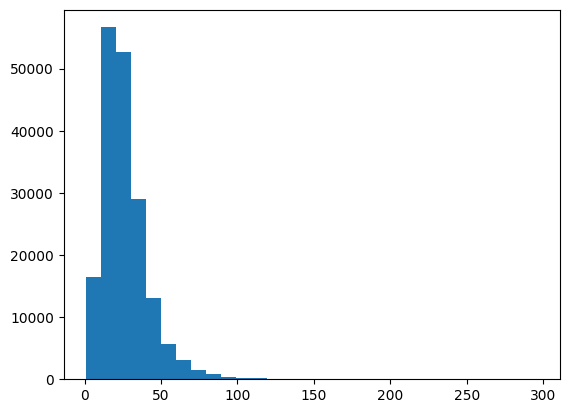

In [34]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths,bins=30) # Getting most occurence sequence length from sequence distribution

The majority of sentences are between 0 to 55 tokens as per above histogram

In [35]:
np.percentile(sentence_lengths,95)   #checking the percentile distribution for sentence token,95% of sentences have token size of 55 or less

55.0

### Creation of text vectorizer layer


                   

In [36]:
max_tokens = 68000  # value 68K taken as reference from table 3.2 of PubMed200K RCT resarch paper https://arxiv.org/pdf/1710.06071.pdf

In [37]:
#creating text vectorizer
#max token- Maximum size of the vocabulary
#output_sequence_length - o/p length of resulting vector sequences
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=55)


In [38]:
text_vectorizer.adapt(train_sentences)

In [39]:
#Validating random sentences from text vectorizer
import random
target_sentence  = random.choice(train_sentences)
print(f"Target Text:\n{target_sentence}")
print(f"\nTarget Text length: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Target Text:
The primary end point , measured at Week @ , was the SLE Responder Index-@ ( SRI-@ , meeting established SRI criteria but with @ point improvement in SELENA-SLEDAI ) .

Target Text length: 31

Vectorized text:
[[    2    56   199   294   156    15    89    10     2  6256  3555   203
  10530  2314  1016 10530   391    72     7   294   194     5 24675     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# Getting current vocabulary and checking vocabulary length
pubmedrct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"total vocabulary words : {len(pubmedrct_20k_vocab)}")


total vocabulary words : 64841


### Create text embedding



In [41]:
#Creating embedding layer
#input_dim - vocabulary size
#output_dim- embedding output dimension

token_embed = layers.Embedding(input_dim=len(pubmedrct_20k_vocab),
                               output_dim= 128,
                               mask_zero=True # allows model to ignore padding tokens during training
                               )

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
The primary end point , measured at Week @ , was the SLE Responder Index-@ ( SRI-@ , meeting established SRI criteria but with @ point improvement in SELENA-SLEDAI ) .

Sentence after vectorization:
[[    2    56   199   294   156    15    89    10     2  6256  3555   203
  10530  2314  1016 10530   391    72     7   294   194     5 24675     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.0346982   0.00614455  0.03383848 ...  0.03909608 -0.02192129
   -0.01885207]
  [-0.02859434  0.03223889  0.02938366 ... -0.03319526  0.0020069
    0.03975803]
  [ 0.04616506  0.03699772  0.04268508 ...  0.0211265   0.01285494
    0.0016313 ]
  ...
  [ 0.04869526 -0.02530441  0.01824267 ... -0.00262809 -0.00810434
    0.04966041]
  [ 0.04869526 -0.02530441  0.01824267 ... -0.00262809 -0.008104

In [42]:
#Enable faster loading on GPU by using tf.data prefetch() and batch() methods
# Create and preprocess training dataset
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_sentences, train_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Create and preprocess validation dataset
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_sentences, val_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Create and preprocess test dataset
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_sentences, test_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Check training dataset
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

Model Structure
```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [43]:
# Define the input layer for text data
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Apply the text vectorization layer to convert text to numerical sequences
text_vector = text_vectorizer(inputs)

# Embed the numerical sequences using token embeddings
embeddings = token_embed(text_vector)

# Apply a 1D convolutional layer with 64 filters and kernel size of 5
conv1d_output = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(embeddings)

# Global max pooling layer to capture key features
global_max_pooling_output = tf.keras.layers.GlobalMaxPooling1D()(conv1d_output)

# Dropout layer for regularization
dropout_output = tf.keras.layers.Dropout(0.2)(global_max_pooling_output)

# Output layer with softmax activation for multi-class classification
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout_output)

# Create the model
model1 = tf.keras.Model(inputs, outputs)


In [44]:
#compile model
model1.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [45]:
# Display model summary
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [46]:
#Fit the model on smaller subset of data (here value is taken as 10%  of training and validation set data as it is more sensible to run smaller experiments and training models on large datasets on GPU takes time)
model1_history =  model1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 72s 124ms/step - loss: 0.8725 - accuracy: 0.6684 - val_loss: 0.5944 - val_accuracy: 0.7806
Epoch 2/10
562/562 [==============================] - 70s 125ms/step - loss: 0.6111 - accuracy: 0.7793 - val_loss: 0.5488 - val_accuracy: 0.8035
Epoch 3/10
562/562 [==============================] - 68s 120ms/step - loss: 0.5779 - accuracy: 0.7872 - val_loss: 0.5286 - val_accuracy: 0.8095
Epoch 4/10
562/562 [==============================] - 67s 120ms/step - loss: 0.5597 - accuracy: 0.7945 - val_loss: 0.5240 - val_accuracy: 0.8068
Epoch 5/10
562/562 [==============================] - 67s 120ms/step - loss: 0.5679 - accuracy: 0.7958 - val_loss: 0.5089 - val_accuracy: 0.8135
Epoch 6/10
562/562 [==============================] - 68s 120ms/step - loss: 0.5591 - accuracy: 0.7924 - val_loss: 0.5024 - val_accuracy: 0.8191
Epoch 7/10
562/562 [==============================] - 67s 119ms/step - loss: 0.5317 - accuracy: 0.8060 - val_loss: 0.4933 - val_ac

In [47]:
# Evaluating on entire validation dataset
model1.evaluate(valid_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.4769 - accuracy: 0.8245


[0.476907342672348, 0.8245068192481995]

In [48]:
# Make predictions
model1_prediction_probablities = model1.predict(valid_dataset)
model1_prediction_probablities

945/945 [==============================] - 7s 8ms/step


array([[4.0893719e-01, 1.7548566e-01, 5.8077753e-02, 2.8874326e-01,
        6.8756066e-02],
       [4.6974272e-01, 4.1887614e-01, 3.1545274e-03, 8.7853707e-02,
        2.0372853e-02],
       [1.7581423e-01, 7.3594111e-04, 6.9385336e-04, 8.2273424e-01,
        2.1792906e-05],
       ...,
       [4.9783383e-05, 5.0430559e-04, 5.6192218e-03, 3.8658356e-05,
        9.9378794e-01],
       [5.0192446e-02, 7.3075736e-01, 4.4461597e-02, 3.2347426e-02,
        1.4224111e-01],
       [9.2062121e-03, 9.8255241e-01, 3.5268003e-03, 1.3536611e-03,
        3.3609134e-03]], dtype=float32)

In [49]:
# Convert prediction probablities to classes
model_1_predictions = tf.argmax(model1_prediction_probablities, axis=1)
model_1_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

### Model1 Results

In [50]:
model1_results= generate_performance_scores(val_labels_encoded, model_1_predictions)


Performance Metrics:

accuracy_score:		0.82451

_____________________________________________
precision_score:	0.82223

_____________________________________________
recall_score:		0.82451

_____________________________________________
f1_score:		0.82154



## Model 2: Feature extraction with pretrained token embedding

Pretrained model used: [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

Reasons for using the above model:
1. Low inference time
2. Computationally inexpensive to use


Model structure:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [52]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [53]:
# Test out the embedding on a random sentence
# Select a random sentence from the training set
random_training_sentence = random.choice(train_sentences)

# Display the random training sentence
print(f"Random training sentence:\n{random_training_sentence}\n")

# Use the TensorFlow Hub embedding layer to embed the random sentence
embedded_sentence = encoder([random_training_sentence])

# Display the embedded sentence (showing the first 20 elements, truncated if necessary)
print(f"Sentence after embedding:\n{embedded_sentence[0][:20]} (truncated output)...\n")

# Display the length of the embedded sentence
print(f"Length of sentence embedding:\n{len(embedded_sentence[0])}")

Random training sentence:
To test the effects of pressure-controlled ( PCV ) and volume-controlled ( VCV ) ventilation during one-lung ventilation ( OLV ) for thoracic surgery on right ventricular ( RV ) function .

Sentence after embedding:
[ 0.01251665  0.03760934  0.0025916  -0.05177359  0.0224129  -0.0766643
  0.03601237 -0.03069751  0.05067188  0.03658909  0.07736617  0.05114786
  0.01607559  0.02004801  0.05246226 -0.03107416 -0.08398724  0.01263481
 -0.06470896 -0.01273841] (truncated output)...

Length of sentence embedding:
512


In [54]:
# Define a feature extractor model using TF Hub layer
input_layer = tf.keras.layers.Input(shape=[], dtype=tf.string)

# Tokenize text and create embedding
embedding_layer = encoder(input_layer)

# Add a fully connected layer on top of the embedding
dense_layer = tf.keras.layers.Dense(128, activation="relu")(embedding_layer)

# Create the output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax")(dense_layer)

# Create the model
model2_feature_extractor_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


In [55]:
# Compile the model
model2_feature_extractor_model.compile(loss="categorical_crossentropy",
                                optimizer=tf.keras.optimizers.Adam(),
                                metrics=["accuracy"])

In [56]:
# Display model summary
model2_feature_extractor_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [57]:
#Fit the model on smaller subset of data (here value is taken as 10%  of training and validation set data as it is more sensible to run smaller experiments and training models on large datasets on GPU takes time)
model2_feature_extractor_model_history =  model2_feature_extractor_model.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 14s 19ms/step - loss: 0.9164 - accuracy: 0.6496 - val_loss: 0.7969 - val_accuracy: 0.6895
Epoch 2/10
562/562 [==============================] - 10s 18ms/step - loss: 0.7674 - accuracy: 0.7021 - val_loss: 0.7530 - val_accuracy: 0.7035
Epoch 3/10
562/562 [==============================] - 9s 16ms/step - loss: 0.7499 - accuracy: 0.7121 - val_loss: 0.7370 - val_accuracy: 0.7134
Epoch 4/10
562/562 [==============================] - 10s 18ms/step - loss: 0.7162 - accuracy: 0.7262 - val_loss: 0.7074 - val_accuracy: 0.7281
Epoch 5/10
562/562 [==============================] - 10s 18ms/step - loss: 0.7241 - accuracy: 0.7233 - val_loss: 0.6870 - val_accuracy: 0.7357
Epoch 6/10
562/562 [==============================] - 9s 15ms/step - loss: 0.7150 - accuracy: 0.7251 - val_loss: 0.6774 - val_accuracy: 0.7397
Epoch 7/10
562/562 [==============================] - 10s 18ms/step - loss: 0.6834 - accuracy: 0.7423 - val_loss: 0.6622 - val_accuracy: 0

In [58]:
# Evaluate on entire validation dataset
model2_feature_extractor_model.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.6533 - accuracy: 0.7522


[0.6533377170562744, 0.7521514892578125]

In [59]:
# Make predictions with feature extraction model
model2_feature_extractor_model_prediction_probablities = model2_feature_extractor_model.predict(valid_dataset)
model2_feature_extractor_model_prediction_probablities

945/945 [==============================] - 15s 15ms/step


array([[3.71297181e-01, 5.17207623e-01, 4.62078693e-04, 1.02649525e-01,
        8.38359073e-03],
       [2.80822426e-01, 6.43345535e-01, 1.89989852e-03, 7.27391690e-02,
        1.19304052e-03],
       [4.69856769e-01, 3.53667550e-02, 2.34994702e-02, 4.38898355e-01,
        3.23786959e-02],
       ...,
       [7.93400162e-04, 8.04708630e-04, 1.97715480e-02, 1.29015185e-04,
        9.78501379e-01],
       [4.82080644e-03, 4.93353345e-02, 1.98512450e-01, 1.02701399e-03,
        7.46304452e-01],
       [5.72757944e-02, 8.30239654e-01, 1.00085028e-01, 7.54659588e-04,
        1.16448710e-02]], dtype=float32)

In [60]:
# Convert the predictions probablities to classes
model2_feature_extractor_model_predictions = tf.argmax(model2_feature_extractor_model_prediction_probablities, axis=1)
model2_feature_extractor_model_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

### Model2 Results

In [61]:
model2_feature_extractor_model_results= generate_performance_scores(val_labels_encoded, model2_feature_extractor_model_predictions)


Performance Metrics:

accuracy_score:		0.75215

_____________________________________________
precision_score:	0.74722

_____________________________________________
recall_score:		0.75215

_____________________________________________
f1_score:		0.74743



## Model 3: Conv1D with character embedding

Approach used:
1. Split the sequences into characters and perform textvectorization on resulting sequence
2. Perform embedding on the sequence obtained from step 1

Model structure:

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

### Creating a character-level tokenizer



In [62]:
def split_into_characters(text):
    """Split a given text into individual characters and join them with spaces."""
    return " ".join(list(text))

# Test the function with a random training sentence
resulting_characters = split_into_characters(random_training_sentence)
resulting_characters

'T o   t e s t   t h e   e f f e c t s   o f   p r e s s u r e - c o n t r o l l e d   (   P C V   )   a n d   v o l u m e - c o n t r o l l e d   (   V C V   )   v e n t i l a t i o n   d u r i n g   o n e - l u n g   v e n t i l a t i o n   (   O L V   )   f o r   t h o r a c i c   s u r g e r y   o n   r i g h t   v e n t r i c u l a r   (   R V   )   f u n c t i o n   .'

In [63]:
# Split the training, validation, and test sets into character-level data
train_chars = [split_into_characters(sentence) for sentence in train_sentences]
val_chars = [split_into_characters(sentence) for sentence in val_sentences]
test_chars = [split_into_characters(sentence) for sentence in test_sentences]
print(train_chars[1])

A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .


In [64]:
# Calculate the character lengths for each training sentence
char_lengths = [len(sentence) for sentence in train_sentences]

# Calculate the total sum of character lengths
total_char_length = sum(char_lengths)

# Calculate the total number of training sentences
num_train_sentences = len(char_lengths)

# Calculate the average character length
average_char_length = total_char_length / num_train_sentences

# Display the average character length
print("Average Character Length in Training Sentences:", average_char_length)

Average Character Length in Training Sentences: 149.3662574983337


(array([7.8590e+03, 3.5206e+04, 4.9626e+04, 4.0112e+04, 2.4025e+04,
        1.2206e+04, 5.8610e+03, 2.5790e+03, 1.2490e+03, 6.2200e+02,
        3.1400e+02, 1.5300e+02, 8.8000e+01, 5.1000e+01, 2.8000e+01,
        1.7000e+01, 1.7000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 4.71666667e+01, 9.33333333e+01, 1.39500000e+02,
        1.85666667e+02, 2.31833333e+02, 2.78000000e+02, 3.24166667e+02,
        3.70333333e+02, 4.16500000e+02, 4.62666667e+02, 5.08833333e+02,
        5.55000000e+02, 6.01166667e+02, 6.47333333e+02, 6.93500000e+02,
        7.39666667e+02, 7.85833333e+02, 8.32000000e+02, 8.78166667e+02,
        9.24333333e+02, 9.70500000e+02, 1.01666667e+03, 1.06283333e+03,
        1.10900000e+03, 1.15516667e+03, 1.20133333e+03, 1.24750000e+03,
        1.29366667e+03, 1.33983333e+03, 1.38600000e+03]),
 <BarContainer object of 30 

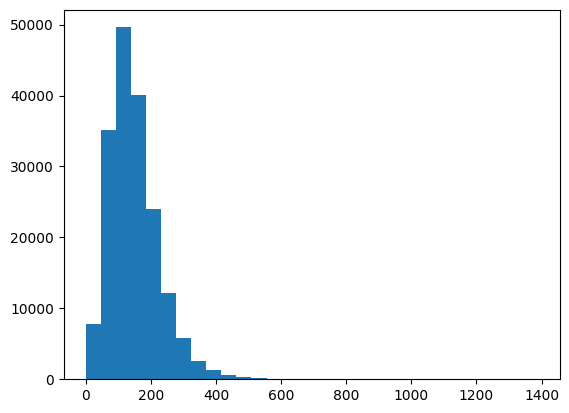

In [65]:
plt.hist(char_lengths,bins =30)   #Checking sequence distribution at character level


The majority of sentences are between 0 to 200 characters long as per above histogram

In [66]:
output_sequence_character_length = int(np.percentile(char_lengths, 95))# Determine character length which covers 95% of sequences

In [67]:
output_sequence_character_length

290

In [68]:
max_tokens= 28 # Total no of characters = total no of characters in alphabet+ space+ OOV(out of vocabulary token)

In [69]:
# Create char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens,
                                    output_sequence_length=output_sequence_character_length,
                                    standardize="lower_and_strip_punctuation")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [70]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Total Number of unique characters in vocabulary: {len(char_vocab)}")

Total Number of unique characters in vocabulary: 28


In [71]:
# Validate character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of characters: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized characters:\n{vectorized_chars}")
print(f"\nLength of vectorized characters: {len(vectorized_chars[0])}")

Charified text:
T h i s   s t u d y   c o m p a r e s   m o d e r a t o r s   o f   i n i t i a t i o n   a n d   m a i n t e n a n c e   o f   h e a l t h   b e h a v i o r   c h a n g e s   .

Length of characters: 77

Vectorized characters:
[[ 3 13  4  9  9  3 16 10 19 11  7 15 14  5  8  2  9 15  7 10  2  8  5  3
   7  8  9  7 17  4  6  4  3  4  5  3  4  7  6  5  6 10 15  5  4  6  3  2
   6  5  6 11  2  7 17 13  2  5 12  3 13 22  2 13  5 21  4  7  8 11 13  5
   6 18  2  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

### Create a character-level embedding


In [72]:
#Create character embedding
#input_dim = no of characters in vocabulary(max tokens)
#output dim= referred embedding dimension from Fig 1 of research paper https://arxiv.org/pdf/1612.05251.pdf
char_embed = layers.Embedding(input_dim=max_tokens,
                              output_dim= 25,
                              mask_zero= True)


In [73]:
# Validate character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
T h i s   s t u d y   c o m p a r e s   m o d e r a t o r s   o f   i n i t i a t i o n   a n d   m a i n t e n a n c e   o f   h e a l t h   b e h a v i o r   c h a n g e s   .

Embedded chars (after vectorization and embedding):
[[[-0.02572104 -0.02568332  0.00486849 ... -0.00210125 -0.00389922
    0.04925635]
  [-0.0154493   0.03582933 -0.01533563 ...  0.02115883  0.0200902
   -0.00939513]
  [ 0.04889871  0.02173683  0.02099041 ...  0.02123541  0.02724531
    0.01972122]
  ...
  [-0.01465497  0.01170807  0.0184296  ... -0.00693461 -0.03020593
   -0.02220659]
  [-0.01465497  0.01170807  0.0184296  ... -0.00693461 -0.03020593
   -0.02220659]
  [-0.01465497  0.01170807  0.0184296  ... -0.00693461 -0.03020593
   -0.02220659]]]

Character embedding shape: (1, 290, 25)


In [74]:
# Create TensorFlow datasets for character-level training and validation data
train_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_chars, train_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_chars, val_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_chars, test_labels_one_hot))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)




#Check training character dataset
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
# Define the input layer for character-level data
input_layer = tf.keras.layers.Input(shape=(1,), dtype="string")

# Apply the character vectorization layer to convert characters to numerical sequences
char_vectors = char_vectorizer(input_layer)

# Apply the character embedding layer to create dense representations of characters
char_embeddings = char_embed(char_vectors)

# Apply a 1D convolutional layer
conv1d_output = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

# Apply global max pooling to capture key features from the convolutional layer
global_max_pooling_output = tf.keras.layers.GlobalMaxPooling1D()(conv1d_output)

# Create the output layer with softmax activation for multi-class classification
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(global_max_pooling_output)

# Create the Conv1D character-level model
model3 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [76]:
# Compile the model
model3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [77]:
# Display the model summary
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [78]:
# Fit the model
model3_history = model3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 15s 25ms/step - loss: 1.2773 - accuracy: 0.4914 - val_loss: 1.0530 - val_accuracy: 0.5964
Epoch 2/10
562/562 [==============================] - 13s 24ms/step - loss: 0.9925 - accuracy: 0.6026 - val_loss: 0.9439 - val_accuracy: 0.6233
Epoch 3/10
562/562 [==============================] - 13s 23ms/step - loss: 0.9119 - accuracy: 0.6405 - val_loss: 0.8690 - val_accuracy: 0.6576
Epoch 4/10
562/562 [==============================] - 13s 23ms/step - loss: 0.8661 - accuracy: 0.6665 - val_loss: 0.8428 - val_accuracy: 0.6682
Epoch 5/10
562/562 [==============================] - 13s 24ms/step - loss: 0.8476 - accuracy: 0.6683 - val_loss: 0.8227 - val_accuracy: 0.6838
Epoch 6/10
562/562 [==============================] - 14s 25ms/step - loss: 0.8337 - accuracy: 0.6807 - val_loss: 0.7989 - val_accuracy: 0.6845
Epoch 7/10
562/562 [==============================] - 14s 24ms/step - loss: 0.8167 - accuracy: 0.6834 - val_loss: 0.7970 - val_accuracy:

In [79]:
# Evaluate model on entire validation dataset
model3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.7570 - accuracy: 0.7124


[0.7570067644119263, 0.7123659253120422]

In [80]:
# Make predictions
model3_prediction_probablities = model3.predict(val_char_dataset)
model3_prediction_probablities

945/945 [==============================] - 8s 8ms/step


array([[0.10798915, 0.48009184, 0.04419916, 0.36099288, 0.0067269 ],
       [0.1550004 , 0.69691867, 0.00157128, 0.14013642, 0.0063732 ],
       [0.15826242, 0.13393715, 0.04089876, 0.66129375, 0.00560792],
       ...,
       [0.02789752, 0.02392408, 0.31705773, 0.04027919, 0.5908415 ],
       [0.1151556 , 0.24840128, 0.32539794, 0.06809452, 0.24295059],
       [0.17017594, 0.74661714, 0.05405805, 0.02342996, 0.00571888]],
      dtype=float32)

In [81]:
# Convert predictions to classes
model3_predictions = tf.argmax(model3_prediction_probablities, axis=1)
model3_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

### Model_3 Results

In [82]:
model3_results= generate_performance_scores(val_labels_encoded, model3_predictions)



Performance Metrics:

accuracy_score:		0.71237

_____________________________________________
precision_score:	0.70696

_____________________________________________
recall_score:		0.71237

_____________________________________________
f1_score:		0.70736



### Comparison of Model Results on Validation set





In [83]:
# Combine validation model results into a DataFrame
combined_validation_model_results = pd.DataFrame({"Naïve Bayes with TF-IDF encoder baseline": model_0_results,
                                  "Conv1D with token embedding": model1_results,
                                  "pretrained feature extractor": model2_feature_extractor_model_results,
                                  "Conv1D with character embedding": model3_results})
combined_validation_model_results = combined_validation_model_results.transpose()
combined_validation_model_results

,accuracy,precision,recall,f1
Naïve Bayes with TF-IDF encoder baseline,0.72183,0.71865,0.72183,0.69893
Conv1D with token embedding,0.82451,0.82223,0.82451,0.82154
pretrained feature extractor,0.75215,0.74722,0.75215,0.74743
Conv1D with character embedding,0.71237,0.70696,0.71237,0.70736


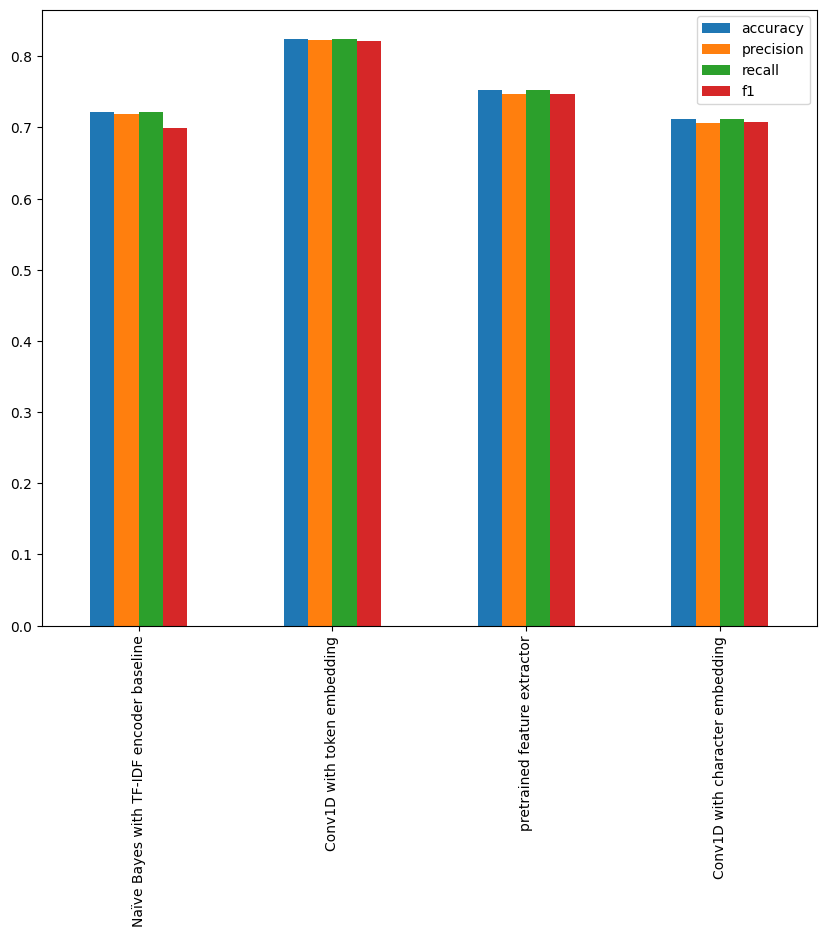

In [84]:
# Plot the combined model results as a bar chart
ax = combined_validation_model_results.plot(kind="bar", figsize=(10, 8))

# Add a legend to the upper right corner
ax.legend(loc="upper right")

# Show the plot
plt.show()

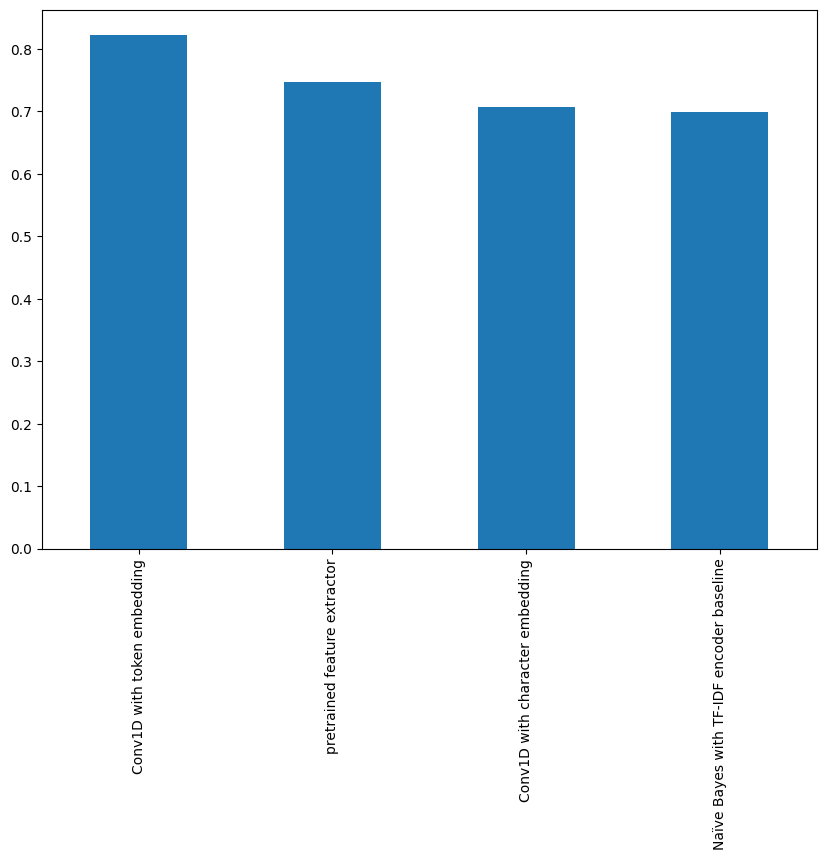

In [85]:
# Sort model results by f1-score
combined_validation_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Comparison of Model Results on Test set


In [86]:
model_1_pred_probs = model1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_2_pred_probs = model2_feature_extractor_model.predict(test_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_3_pred_probs = model3.predict(test_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

942/942 [==============================] - 9s 9ms/step


In [87]:
# Generate performance scores on Model0,Model1,Model2,Model3 results for test set
model0_test_results= generate_performance_scores(test_labels_encoded, test_predictions)
model1_test_results= generate_performance_scores(test_labels_encoded, model_1_preds)
model2_test_results= generate_performance_scores(test_labels_encoded, model_2_preds)
model3_test_results= generate_performance_scores(test_labels_encoded, model_3_preds)


Performance Metrics:

accuracy_score:		0.71667

_____________________________________________
precision_score:	0.71243

_____________________________________________
recall_score:		0.71667

_____________________________________________
f1_score:		0.69251


Performance Metrics:

accuracy_score:		0.81832

_____________________________________________
precision_score:	0.81525

_____________________________________________
recall_score:		0.81832

_____________________________________________
f1_score:		0.8149


Performance Metrics:

accuracy_score:		0.74389

_____________________________________________
precision_score:	0.73834

_____________________________________________
recall_score:		0.74389

_____________________________________________
f1_score:		0.73895


Performance Metrics:

accuracy_score:		0.71113

_____________________________________________
precision_score:	0.70615

_____________________________________________
recall_score:		0.71113

_______________________________________

In [88]:
# Combine test model results into a DataFrame
combined_test_model_results = pd.DataFrame({"Naïve Bayes with TF-IDF encoder baseline": model0_test_results,
                                  "Conv1D with token embedding": model1_test_results,
                                  "pretrained feature extractor": model2_test_results,
                                  "Conv1D with character embedding": model3_test_results})
combined_test_model_results = combined_test_model_results.transpose()
combined_test_model_results

,accuracy,precision,recall,f1
Naïve Bayes with TF-IDF encoder baseline,0.71667,0.71243,0.71667,0.69251
Conv1D with token embedding,0.81832,0.81525,0.81832,0.81490
pretrained feature extractor,0.74389,0.73834,0.74389,0.73895
Conv1D with character embedding,0.71113,0.70615,0.71113,0.70598


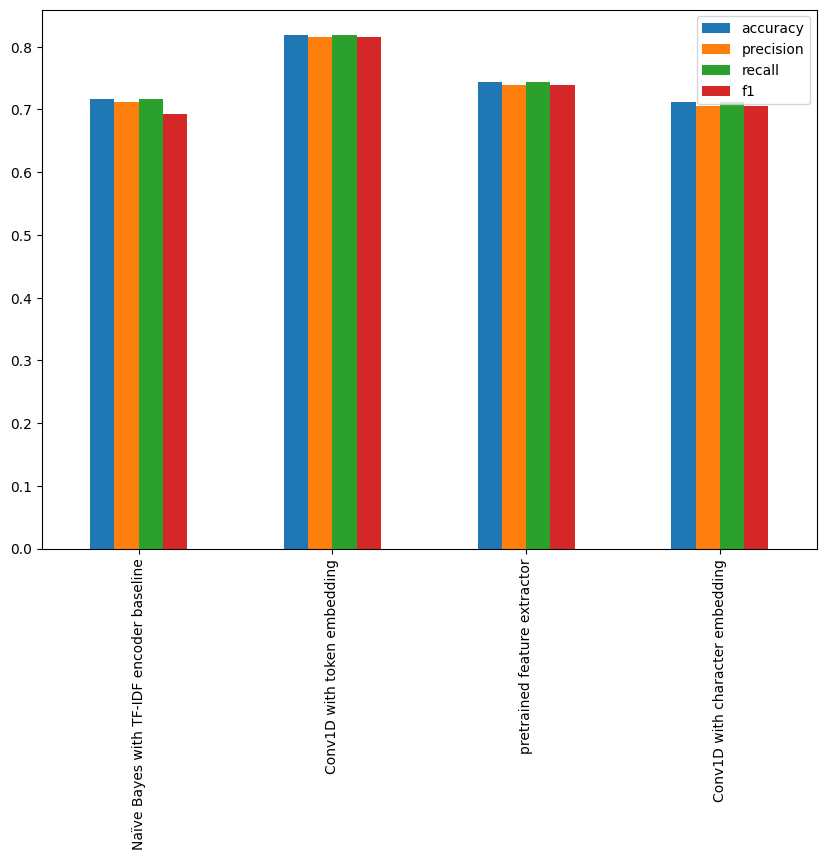

In [89]:
# Plot the combined model results as a bar chart
ax = combined_test_model_results.plot(kind="bar", figsize=(10, 7))

# Add a legend to the upper right corner
ax.legend(loc="upper right")

# Show the plot
plt.show()

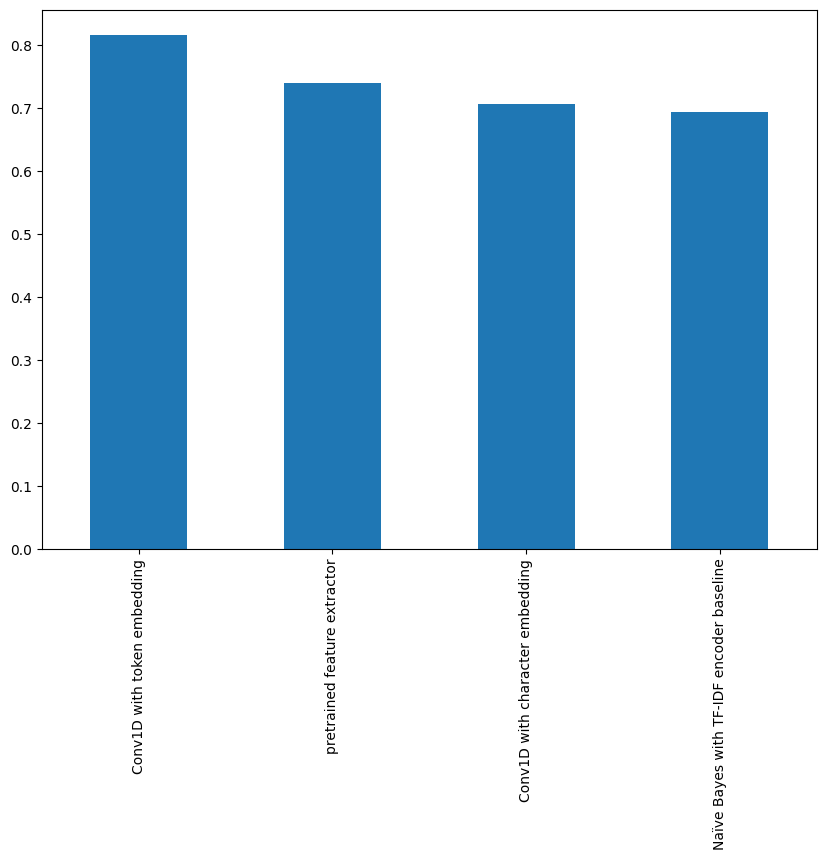

In [90]:
# Sort model results by f1-score
combined_test_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [92]:
print("Classification metrics for Model 1")
print(classification_report(test_labels_encoded, model_1_preds, target_names=class_names))

Classification metrics for Model 1
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.66      0.66      3621
 CONCLUSIONS       0.74      0.76      0.75      4571
     METHODS       0.87      0.92      0.90      9897
   OBJECTIVE       0.73      0.50      0.59      2333
     RESULTS       0.87      0.88      0.88      9713

    accuracy                           0.82     30135
   macro avg       0.77      0.74      0.75     30135
weighted avg       0.82      0.82      0.81     30135



In [93]:
def plot_custom_confusion_matrix(y_true, y_pred, classes='auto', figsize=(12, 12), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create custom confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Blues',  # Change colormap to Blues
        annot_kws={"size": text_size},
        fmt=',',  # Use commas as thousand separators
        linewidths=2, linecolor='gray',  # Change line color to gray
        cbar=False,  # Remove color bar
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Custom Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=22)  # Increase x-axis label font size
    disp.set_ylabel('True Label', fontsize=22)  # Increase y-axis label font size

    # Plot custom confusion matrix
    plt.show()

    return

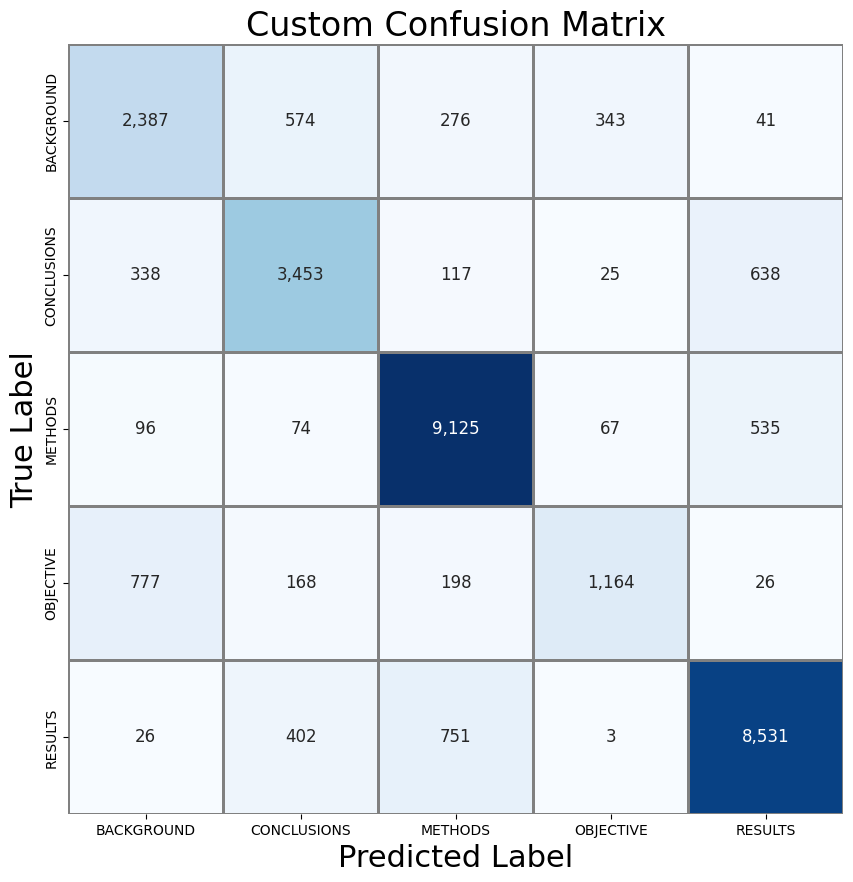

In [94]:
#Print confusion matrix
plot_custom_confusion_matrix(
    test_labels_encoded,
    model_1_preds,
    figsize=(10, 10),
    classes=list(class_names))

### Evaluating model on test dataset

As Model 1: Conv1D with token embedding is best performing model having highest accuracy as well as f1 score among all the models on validation as well as test set, model 1 is taken for making the prediction and comparing with the truth labels.

In [95]:
test_pred_classes = [label_encoder.classes_[pred] for pred in model_1_preds]

# Adding below columns in test dataframe for comparing with truth label
prediction column- contains model's prediction for a given sample.

pred_prob  column- contains the model's maximum prediction probabiliy for a given sample.

correct    column- indicates whether or not the model's prediction matches the sample's target label.

In [96]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(model_1_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]

In [97]:
test_df.head(50)

,abstract_text,line_number,total_lines,target,prediction,pred_prob,correct
0,This study analyzed liver function abnormaliti...,0,9,BACKGROUND,METHODS,0.523332,False
1,A post hoc analysis was conducted with the use...,1,9,RESULTS,METHODS,0.932483,False
2,Liver function tests ( LFTs ) were measured at...,2,9,RESULTS,METHODS,0.969578,False
3,Survival analyses were used to assess the asso...,3,9,RESULTS,METHODS,0.569774,False
4,The percentage of patients with abnormal LFTs ...,4,9,RESULTS,RESULTS,0.963710,True
5,When mean hemodynamic profiles were compared i...,5,9,RESULTS,RESULTS,0.998498,True
6,Multivariable analyses revealed that patients ...,6,9,RESULTS,RESULTS,0.997658,True
7,Abnormal LFTs are common in the ADHF populatio...,7,9,CONCLUSIONS,BACKGROUND,0.526140,False
8,Elevated MELD-XI scores are associated with po...,8,9,CONCLUSIONS,CONCLUSIONS,0.521422,True
9,Minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,CONCLUSIONS,0.669843,False


In [98]:
#Inspect Most 50 Inaccurate Predictions
top_50_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:50]
top_50_wrong


,abstract_text,line_number,total_lines,target,prediction,pred_prob,correct
9130,The expected CIN rate was similar for the two ...,4,11,METHODS,RESULTS,0.999699,False
21186,Mean distraction rates were similar between gr...,8,18,METHODS,RESULTS,0.999689,False
30065,There was no significant difference in gender ...,4,13,METHODS,RESULTS,0.999532,False
13598,-@ % vs. Fish : -@ % vs. Fish + S : -@ % ; p <...,6,10,METHODS,RESULTS,0.999511,False
19313,( @ ) The differences in heart rate and blood ...,17,20,METHODS,RESULTS,0.999474,False
6028,Courses were repeated every @ to @ weeks .,5,16,RESULTS,METHODS,0.999307,False
137,"Compared to group S , there was a transient im...",8,9,CONCLUSIONS,RESULTS,0.999134,False
12158,"In the saffron group , there was no decline in...",9,13,METHODS,RESULTS,0.998972,False
20346,Outcomes were examined using Kaplan-Meier and ...,3,9,RESULTS,METHODS,0.998949,False
28424,"However , the subgroup of subjects , which inh...",5,11,BACKGROUND,RESULTS,0.998411,False
